In [2]:
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from copy import deepcopy

## Dataset Info 

Data set consists of set of EV-charging stations from Italy.

In [3]:
# define Path 
train_data = glob("/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/data/evcharger_data/train/*/*.jpg")
print("Total training files ",len(train_data))

valid_data = glob("/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/data/evcharger_data/valid/*/*.jpg")
print("Total validation files ",len(valid_data))

test_data = glob("/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/data/evcharger_data/test/*/*.jpg")
print("Total training files ",len(test_data))

class_name = {0:'ev_charger'}
print(class_name)

Total training files  300
Total validation files  19
Total training files  4
{0: 'ev_charger'}


## Add Functions 

In [19]:
def read_annotations(annotations_path,img_shape):
    with open(annotations_path, 'r') as f:
            annotations = f.read().splitlines()
    img_annot = list()
    class_ids = list()
    for annt in annotations:
        cls_id = annt[0]
        x,y = annt.split()[1:3]
        w,h = annt.split()[3:5]
        x1,y1,x2,y2= xywh2xyxy([x,y,w,h])
        x1,x2 = int(x1 * img_shape[1]),int(x2 *img_shape[1])
        y1,y2 = int(y1 * img_shape[0]),int(y2 *img_shape[0])
        
        img_annot.append([x1,y1,x2,y2])
        class_ids.append(cls_id)
    return [img_annot,class_ids]


def draw_boxes(img, img_bboxes ,color=(238, 0, 226),scale=False):
    """
    Add bounding box onto image
    img : image 
    img_bboxes: Bounding Boxes
    """
    img_cpy = deepcopy(img)
    for cords in img_bboxes:
        x1,y1,x2,y2 = cords
        cv2.rectangle(img_cpy, (x1, y1), (x2, y2), color, 3)
    if scale:
        img_cpy = cv2.resize(img_cpy,(640,640),interpolation=cv2.INTER_AREA)
    return img_cpy


def plot_boxes(img, boxes, score=None, name='Object', color=(132, 255, 0)):
    line_width = max(round(sum(img.shape) / 2 * 0.003), 2)
    if score:
        w, h = \
            cv2.getTextSize("{} {:.2f}".format(name, score), 0, fontScale=line_width / 3, thickness=max(line_width - 1, 1))[0]
    else:
        w,h = cv2.getTextSize("{}".format(name), 0, fontScale=line_width / 3, thickness=max(line_width - 1, 1))[0]
    x1, y1, x2, y2 = boxes
    # add a context line on bbox
    outside = y1 - h - 3 >= 0  # label fits outside box
    p2 = x1 + w, y1 - h - 3 if outside else y1 + h + 3
    img = cv2.rectangle(img, (x1, y1), p2, color, -1, cv2.LINE_AA)
    if score:
        text = "{} {:.2f}".format(name, score)
    else:
        text = "{}".format(name)
    img = cv2.putText(img, text,(x1, y1 - 2 if outside else y1 + h + 3), 0, line_width / 2, (255, 255, 255), 2,lineType=cv2.LINE_AA)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), color, line_width // 3, lineType=cv2.LINE_AA)
    return img

def display_images(images, columns=5, width=15, height=17, max_images=15, label_wrap_length=50, label_font_size=8):
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
    height = max(height, int(len(images)/columns) * height)
    
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        
        img = cv2.imread(image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label_path = osp.dirname(image).replace('images','labels/') + osp.basename(image).replace('jpg','txt')
        
        bboxes,cls_ids = read_annotations(label_path,img.shape[:2])
        upadted_img = draw_boxes(img,bboxes,scale=True)
        
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.title("image-"+str(i+1))
        plt.tight_layout()
        plt.imshow(upadted_img)
        
def xywh2xyxy(coordinates:list()):
    x,y,w,h = np.asanyarray(coordinates,dtype=np.float32)
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    return [x1,y1,x2,y2]
    

### Data Visualization

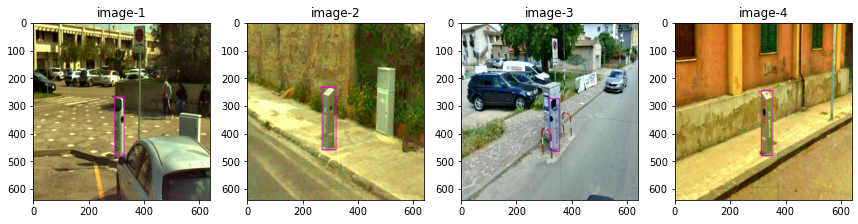

In [21]:
sample_test = np.random.choice(valid_data,4)
display_images(sample_test)

### Data Augmentations 

In [13]:
import os
import os.path as osp
import numpy as np
import albumentations as A
import imageio
from tqdm import tqdm 

path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/notebooks"

class ImageAugmentation:
    def __init__(self, classes, probability=0.5, data_format='pascal_voc'):
        self.p = probability
        self.classes = classes
        self.__aug_format__ = data_format
        # define variables
        self.augmentation = A.Compose([A.CLAHE(p=self.p),
                                       A.Rotate(limit=10, p=self.p),
                                       A.HorizontalFlip(p=self.p),
                                       A.MotionBlur(p=self.p),
                                       A.Blur(blur_limit=2, p=self.p),
                                       A.RandomBrightnessContrast(p=self.p)],
                                      bbox_params=A.BboxParams(format='pascal_voc'))

    def batch_augmentation(self, images, labels, save=False,cls_dict=None, out_path='result'):
        print("Augmenting Batch data")
        for img_name, label_name in tqdm(zip(images, labels),total=len(images)):
            img = cv2.imread(img_name)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            cords, cls_name = read_annotations(label_name,img.shape[:2])
            aug_image, aug_bbox = self.augment_data(img, cords, cls_name)
            if save:
                os.makedirs(osp.join(out_path,'images'),exist_ok=True)
                os.makedirs(osp.join(out_path,'labels'),exist_ok=True)
                self.save_augmented_image(aug_image, file_name=osp.basename(img_name),out_path=osp.join(out_path, 'images'))
                
                if cls_dict is None:
                    print("Class mapping can not be none - will not save bounding boxes")
                else:
                    self.save_augmented_text(aug_bbox, cls_dict, filename=osp.basename(img_name)+'.txt',
                                         out_path=osp.join(out_path, 'labels'))
        return

    def augment_data(self, img, cords, class_name):
        augmented_image = None
        augmented_bboxes = None
        boxes = []
        
        for box, name in zip(cords, class_name):
            box.append(int(name))
            boxes.append(box)
        try:
            augmented_image, augmented_bboxes = self.transform_image(img, boxes, class_name)
            augmented_bboxes = augmented_bboxes.astype('int32')
        except AssertionError as err:
            self.logger.error("{}".format(err))
        return augmented_image, augmented_bboxes

    def transform_image(self, image, annotations, class_name):
        transformed = self.augmentation(image=image, bboxes=annotations, class_labels=class_name)
        return transformed['image'], np.asarray(transformed['bboxes'])

    def save_augmented_image(self, image, file_name, out_path='result'):
        if not out_path:
            os.makedirs(out_path, exist_ok=True)
        imageio.imwrite(osp.join(out_path, "augmented_" + file_name), image)

    def save_augmented_text(self, cords, class_names, filename, out_path='result'):
        augmented_file = osp.join(out_path, 'augmented_' + filename)
        with open(augmented_file, 'w+') as aug:
            for box in cords:
                cls_id = list(class_names.keys())[
                    int(box[-1])]  # aug_annotations are saved as [xmin,ymin,xmax,ymax ,cls_id]
                aug.write("{} {} {} {} {}\n".format(str(box[0]), str(box[1]), str(box[2]), str(box[3]), str(cls_id)))


In [14]:
image_aug = ImageAugmentation(classes = class_name)
sample_test = np.random.choice(valid_data,4)

sample_labels = list(map(lambda image: osp.dirname(image).replace('images','labels/') + osp.basename(image).replace('jpg','txt'),sample_test))

image_aug.batch_augmentation(sample_test,
                             sample_labels,
                             cls_dict=class_name,
                             out_path=osp.join(path,'results'),save=True)

Augmenting Batch data


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 33.07it/s]


0

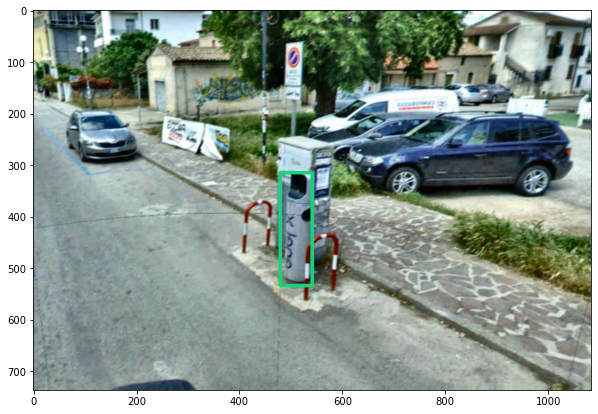

In [22]:
out_path = osp.join(path,'results')
aug_images = glob(osp.join(out_path,'images/*.jpg'))
aug_labels = [aug_name.replace('images','labels') + '.txt' for aug_name in aug_images]


plt.figure(figsize=(10,9))


def display_augmentations(imgfile,label_file):
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    with open(label_file,'r') as fd:
        annotations = fd.readlines()
    for annt in annotations:
        x1, y1, x2, y2, cls = annt.split()
        x1,y1 = int(x1) , int(y1)
        x2,y2 = int(x2) , int(y2)
        img = cv2.rectangle(img,(x1,y1),(x2,y2),(24,211,123),5)
        plt.imshow(img)
    return 0

random_val = np.random.randint(0,len(aug_images))

display_augmentations(aug_images[random_val],aug_labels[random_val])